In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import scipy
from statsmodels.stats.diagnostic import het_breuschpagan
import phik
from utils import *

In [2]:
#!pip install phik==0.10.0

In [3]:
df = pd.read_csv('insurance.csv')
df['children'] = df['children'].replace([2,3,4,5],[1,1,1,1])
df = df.astype({"sex":'category', "smoker":'category',"region":'category', "children":'category'}) 

# EDA and Visualization

## Visualizing Individual Numerical Predictor Variables vs. Response Variable

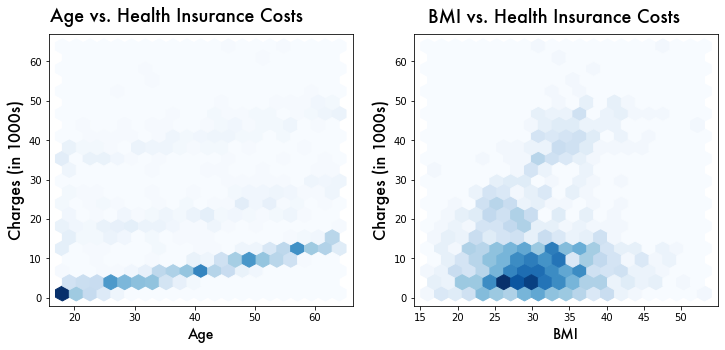

In [4]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

var = ['Age', 'BMI']
for i, vari in enumerate(var):
    ax[i].hexbin(x = df[f'{vari}'.lower()], y = df['charges']/1000, gridsize=20, cmap = 'Blues')
    ax[i].text(16,70, f'{vari} vs. Health Insurance Costs', fontsize=18, fontweight='bold', fontname='Futura')
    ax[i].set_xlabel(f'{vari}', fontname = 'Futura', fontsize=14)
    ax[i].set_ylabel('Charges (in 1000s)', fontname = 'Futura',  fontsize=16)

Commentary: There is a clear linear relationship between age and charges. <br>
The plot BMI vs Charges appears to be split into two populations with different linear relationships. <br>

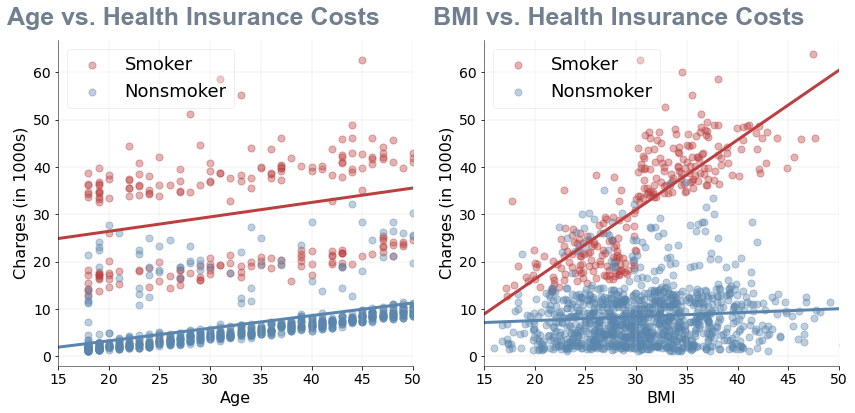

In [5]:
smk = df[df['smoker']=='yes']; nsmk = df[df['smoker']=='no']
bmi = df['bmi']; charges = df['charges']; age = df['age']
dict_colors={'xkcd:dull red':[smk,'Smoker'],'xkcd:dusty blue':[nsmk,'Nonsmoker']}

fig, ax = plt.subplots(1,2, figsize=(14,6))

for idx, col in enumerate(['Age','BMI']):
    ax[idx].text(10,70,f'{col} vs. Health Insurance Costs', fontsize=25, fontweight='bold', fontname='Arial', color = 'slategrey')
    ax[idx].set_xticklabels(range(15,55,5), fontsize=14)
    ax[idx].set_yticklabels(range(-10,65,10), fontsize=14)
    ax[idx].set_xlabel(f'{col}', fontsize=16)
    ax[idx].set_ylabel('Charges (in 1000s)', fontsize=16)
    ax[idx].set_facecolor('white')
    ax[idx].grid(color='lightgrey', linestyle='-', linewidth=.3)
    ax[idx].set_xlim([15,50])
        
    for key in (dict_colors):
        ax[idx].scatter(dict_colors[key][0][f'{col.lower()}'], dict_colors[key][0]['charges']/1000, s=50, c=f'{key}', alpha = 0.4, label = f'{dict_colors[key][1]}')
        m, b = np.polyfit(dict_colors[key][0][f'{col.lower()}'], dict_colors[key][0]['charges']/1000, 1)
        x=np.linspace(15,50)
        ax[idx].plot(x, m*x + b, color = f'{key}',linewidth=3)
    ax[idx].legend(framealpha=.3, frameon=True, prop={'size': 18})
    set_spines(ax[idx])


The population of those who smoke consistently pay more than those who do not throughout all ages and BMI.

### Visualizing the Correlation Between All Variables using PhiK Correlation Matrix
The PhiK measure is similar to the Pearson correlation coefficient in its interpretation but it works consistently between categorical, ordinal and interval variables.

interval columns not set, guessing: ['age', 'bmi', 'charges']


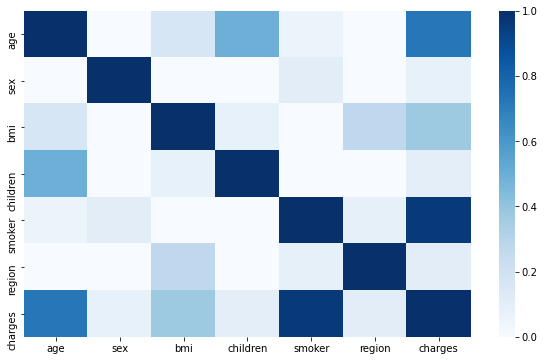

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

sns.heatmap(df.phik_matrix(),cmap = 'Blues')
plt.show()

The strongest correlations are with the response variable which is ideal. There does not appear to be significant multicollinearity.

### Visualizing Additional Trends

##### Age Vs. Charges Colored with Region

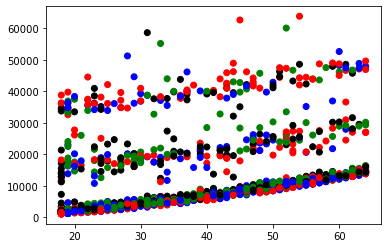

In [7]:
#Age Vs. Charges Colored with Region
colors = {'southeast':'red', 'southwest':'blue', 'northwest':'green', 'northeast':'black'}

plt.scatter(df['age'], df['charges'], c=df['region'].apply(lambda x: colors[x]))

plt.show()

All regions appear to be randomly distributed.

##### Age Vs. Charges Colored with Children/No Children

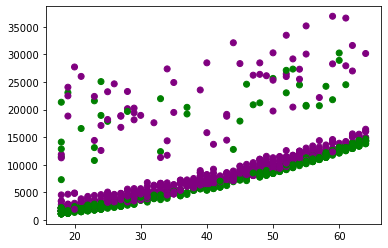

In [8]:
#created a dictionary to afford to explore potential cutoffs
colors = {0:'green', 1:'purple', 2:'purple', 3:'purple', 4:'purple',5:'purple'}

plt.scatter(nsmk['age'], nsmk['charges'], c=nsmk['children'].apply(lambda x: colors[x]))

plt.show()

For the lowest tier (comprised of non-smokers as previously shown), those who do not have children pay less on insurance.

# Model Fitting

In [9]:
y_name = 'charges'
X_names = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
lr = LinearRegression(y_name, X_names, df)
model = lr.fit_ols()

In [10]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     499.3
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:32:33   Log-Likelihood:                -13549.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -1.2e+04    993.991    -12.074      0.000    -1.4e+04   -1.01e+04
sex[T.male]          -126.4104    333.313     -0.379      0.705    -780.287     527.466
children[T.1]         999.5804    335.880      2.976      0.003     340.668    1658.493
smoker[T.yes]        2.385e+04    413.627     57.660      0.000     2.3e+04    2.47e+04
region[T.northwest]  -352.2153    476.882     -0.739      0.460   -1287.738     583.308
region[T.southeast] -1057.3312    479.275     -2.206      0.028   -1997.549    -117.114
region[T.southwest]  -944.2598    478.401     -1.974      0.049   -1882.764      -5.755
age                   256.9072     11.915     21.562      0.000     233.533     280.281
bmi                   339.5097     28.631     11.858      0.000     283.342     395.678
==============================================================================
Omnibus:                      294.707   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              695.349
Skew:                           1.195   Prob(JB):                    1.02e-151
Kurtosis:                       5.600   Cond. No.                         313.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All predictors except for sex are significant predictors of charges. Since there is at least one level that is significantly different in "charges" from the baseline level for both of the categories "children" and "region", we know that the categories entirely have a significant role in predicting "charges". 

In [11]:
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
sex,1.0,6.435902e+08,6.435902e+08,17.473263,3.104289e-05
children,1.0,8.006638e+08,8.006638e+08,21.737760,3.440406e-06
smoker,1.0,1.207210e+11,1.207210e+11,3277.536727,0.000000e+00
region,3.0,1.180499e+08,3.934996e+07,1.068339,3.614650e-01
age,1.0,1.966094e+10,1.966094e+10,533.788053,1.477155e-99
bmi,1.0,5.179078e+09,5.179078e+09,140.610268,6.655185e-31
Residual,1329.0,4.895087e+10,3.683286e+07,NaN,NaN


Based on the sequential ANOVA test, we should drop region from the model. This is divergent from the conclusion in the individual t-test.

In [12]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
sex,5.297821e+06,1.0,0.143834,7.045593e-01
children,3.262144e+08,1.0,8.856615,2.973079e-03
smoker,1.224565e+11,1.0,3324.653125,0.000000e+00
region,2.363591e+08,3.0,2.139024,9.352488e-02
age,1.712372e+10,1.0,464.903499,1.162116e-88
bmi,5.179078e+09,1.0,140.610268,6.655185e-31
Residual,4.895087e+10,1329.0,NaN,NaN


Based on the partial ANOVA test, we should drop region and sex from the model. Again, while the individual t-test has a different conclusion for region, it has the same conclusion for "sex" .

# Multicollinearity: VIF Score

In [13]:
lr.vif_score()

,VIF Factor,features
0,35.891002,Intercept
1,1.008828,sex[T.male]
2,1.003879,children[T.1]
3,1.012088,smoker[T.yes]
4,1.519226,region[T.northwest]
5,1.652486,region[T.southeast]
6,1.528925,region[T.southwest]
7,1.017269,age
8,1.106585,bmi


Since all of the VIF scores are roughly equal to 1, we can conclude that there are no variables correlated with one another. This is consistent with the correlation matrix plotted previously.

# Checking for Hetereoscedasticity

## Fitted Values vs. Residual Plot

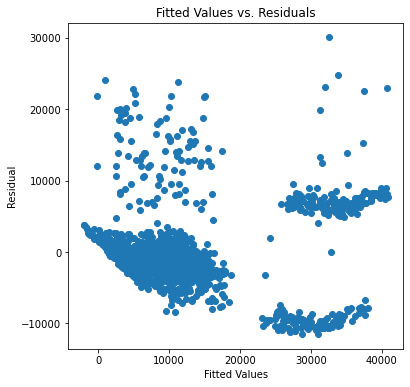

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
lr.fitted_residuals(ax=ax)
plt.show()

The residuals do not form a "horizontal band" around the 0 line. This suggests that the variances of the error terms are not equal.

## Numerical Test: Breusch-Pagan Test

In [15]:
lr.bp_test()

{'LM Statistic': 124.39581043099527, 'LM-Test p-value': 4.093354016695784e-23}

Since the p-value is less than an alpha level of 0.05 (or even 0.01), then we can reject the null hypothesis and conclude that there is a significant hetereoscedasticity issue, confirming our prior observation from the fitted vs. residual plot. <br>

This result was expected since our exploratory analysis revealed that it may be better to partition the data into subgroups with the most striking differentiation being smokers and non-smokers. We can either:
1. Use hetereoscedasticity methods to correct the test results.
2. Split data into two separate models for smokers and non-smokers.

## Approach 1 for Heteroscedastcity: Improve the Model 

### Dropping the Influential Points

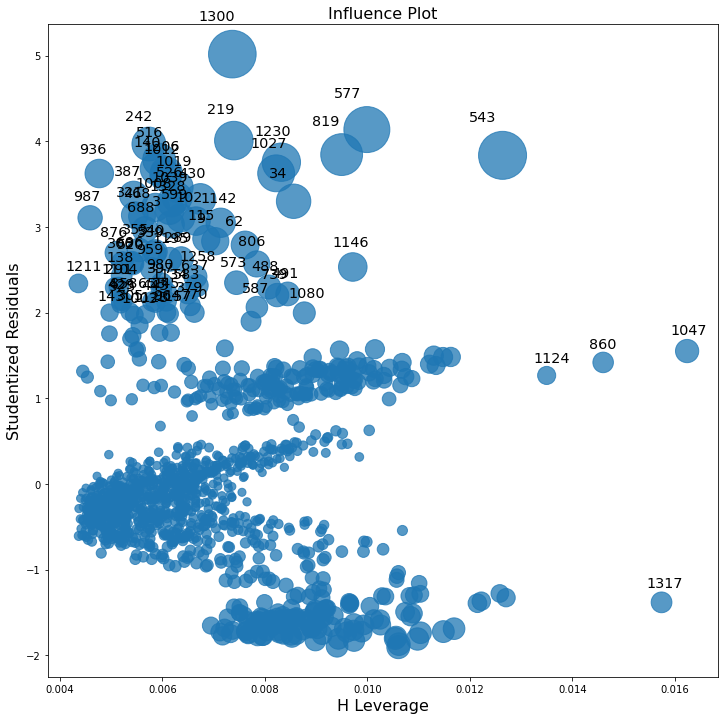

In [16]:
#graphical representation of the influences()
fig, ax = plt.subplots(figsize=(12,12))
lr.plot_influence(ax=ax)
plt.show()
#size of points are given by cook's dist value
#the points with big size and out of the (-3,3) should raise a flag

In [17]:
df_drop = lr.drop_influential_points()

In [18]:
lr_drop = LinearRegression(y_name, X_names, df_drop)
model_drop = lr_drop.fit_ols()

In [19]:
lr_drop.bp_test()

{'LM Statistic': 603.1258550039928, 'LM-Test p-value': 4.979603839742586e-125}

In [20]:
model_drop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     797.4
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:32:35   Log-Likelihood:                -12615.
No. Observations:                1278   AIC:                         2.525e+04
Df Residuals:                    1269   BIC:                         2.530e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.292e+04    788.624    -16.385      0.000   -1.45e+04   -1.14e+04
sex[T.male]            17.8268    264.454      0.067      0.946    -500.988     536.642
children[T.1]         733.4602    266.165      2.756      0.006     211.288    1255.633
smoker[T.yes]        2.395e+04    327.217     73.178      0.000    2.33e+04    2.46e+04
region[T.northwest]  -569.2899    379.723     -1.499      0.134   -1314.244     175.664
region[T.southeast]  -979.1687    380.835     -2.571      0.010   -1726.304    -232.034
region[T.southwest]  -698.1614    378.563     -1.844      0.065   -1440.839      44.516
age                   254.0531      9.477     26.808      0.000     235.462     272.645
bmi                   346.8064     22.701     15.277      0.000     302.272     391.341
==============================================================================
Omnibus:                       22.178   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.625
Skew:                           0.255   Prob(JB):                     2.73e-06
Kurtosis:                       3.470   Cond. No.                         313.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

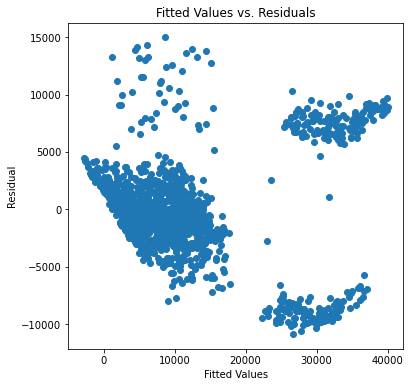

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
lr_drop.fitted_residuals(ax=ax)
plt.show()

### Observations
Dropping the influential points does not help the heteroscedasticity issue.

### Log Transformation for Heteroscedasticity
Since the residual plot doesn't change proportionally with the fitted values, the ln transformation will likely not work well.

In [22]:
df_log = df.copy()
df_log['log_charges']=np.log(df['charges'])

In [23]:
lr_log = LinearRegression(y_name='log_charges', X_names=X_names, df=df_log)
model_log = lr_log.fit_ols()

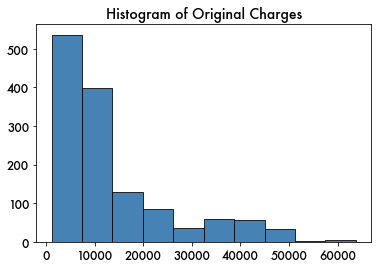

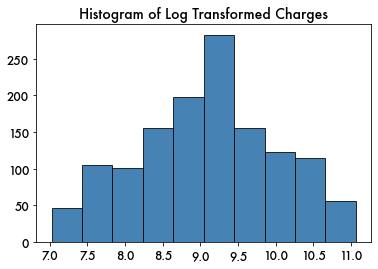

In [24]:
plot_hist(df_log['charges'],'Histogram of Original Charges')
plot_hist(df_log['log_charges'],'Histogram of Log Transformed Charges')

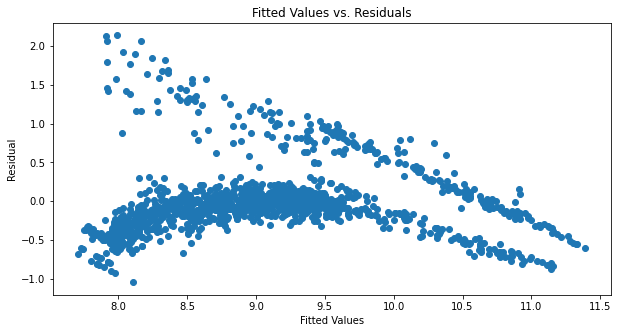

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
lr_log.fitted_residuals(ax=ax)
plt.show()

In [26]:
lr_log.bp_test()

{'LM Statistic': 79.07032496033362, 'LM-Test p-value': 7.520502062037393e-14}

This does improve the model; however, there is still a significant heteroscedasticity issue.

### Robust Methods for Heteroscedasticity

#### Let's see if using a robust linear model with the various functions for downweighting outliers on the log transformed and non-log transformed data helps with the heteroscedastcity issue.

##### Function for Downweighting Outliers: Huber

In [27]:
from utils import *
rlr_regular = RobustLinearRegression(y_name, X_names, df)
rlr_regular.bp_test_each_norm()

,Norm,LM Statistic,LM-Test p-value
0,HuberT,309.642378,3.645811e-62
1,LeastSquares,124.395810,4.093354e-23
2,Hampel,405.376752,1.325366e-82
3,AndrewWave,397.864641,5.361933e-81
4,TrimmedMean,389.789306,2.859421e-79
5,RamsayE,400.149307,1.740344e-81


In [28]:
rlr_log = RobustLinearRegression('log_charges', X_names, df_log)
rlr_log.bp_test_each_norm()

,Norm,LM Statistic,LM-Test p-value
0,HuberT,64.046041,7.448954e-11
1,LeastSquares,79.070325,7.520502e-14
2,Hampel,73.762244,8.725142e-13
3,AndrewWave,78.557263,9.536643e-14
4,TrimmedMean,70.067692,4.764260e-12
5,RamsayE,66.998288,1.940415e-11


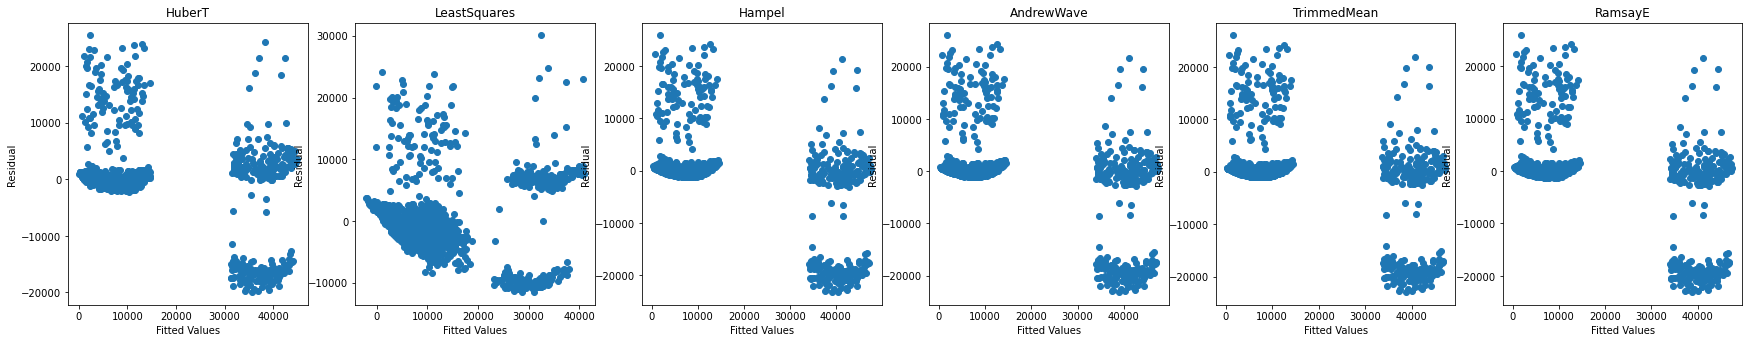

In [29]:
fig, ax = plt.subplots(1,6, figsize=(30,4))
rlr_regular.fitted_residuals_each_norm(ax=ax)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.25, wspace=0.2)

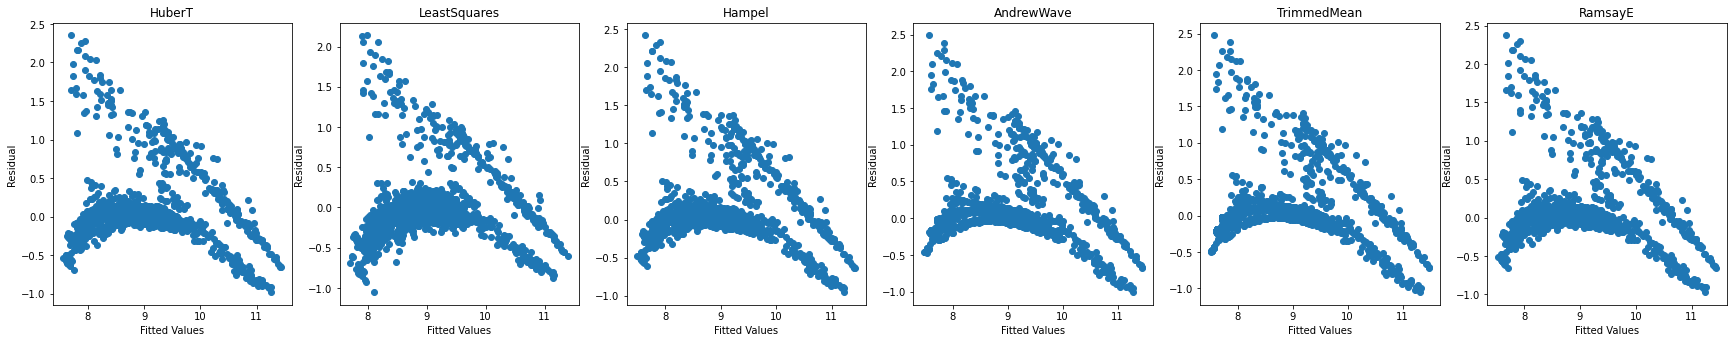

In [30]:
fig, ax = plt.subplots(1,6, figsize=(30,4))
rlr_log.fitted_residuals_each_norm(ax=ax)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.25, wspace=0.2)

None of the robust linear models fixed the heteroscedasticity issue. We will move on to creating two different models for the population of smokers and nonsmokers. Below is the summary table for the best performing model: Huber Loss

In [31]:
model_tst = rlm('log_charges~age+sex+bmi+children+smoker+region',data=df_log).fit()
model_tst.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:            log_charges   No. Observations:                 1338
Model:                            RLM   Df Residuals:                     1329
Method:                          IRLS   Df Model:                            8
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 02 Dec 2020                                         
Time:                        15:32:37                                         
No. Iterations:                    36                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.9025      0.036    194.257      0.000       6.833       6.972
sex[T.male]            -0.0776      0.012     -6.516      0.000      -0.101      -0.054
children[T.1]           0.2342      0.012     19.507      0.000       0.211       0.258
smoker[T.yes]           1.6009      0.015    108.267      0.000       1.572       1.630
region[T.northwest]    -0.0490      0.017     -2.872      0.004      -0.082      -0.016
region[T.southeast]    -0.1297      0.017     -7.572      0.000      -0.163      -0.096
region[T.southwest]    -0.0981      0.017     -5.737      0.000      -0.132      -0.065
age                     0.0404      0.000     94.751      0.000       0.040       0.041
bmi                     0.0061      0.001      5.983      0.000       0.004       0.008
=======================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

## Split into Groups: Smoker vs. Non-Smoker

In [32]:
smk_test = smk.sample(n = 10)
smk_train = smk.drop(smk_test.index.tolist())

In [33]:
nsmk_test = nsmk.sample(n = 10)
nsmk_train = nsmk.drop(nsmk_test.index.tolist())

In [34]:
smk_train = smk_train.drop(['smoker'], axis=1)
smk_test = smk_test.drop(['smoker'], axis=1)

nsmk_train = nsmk_train.drop(['smoker'], axis=1)
nsmk_test = nsmk_test.drop(['smoker'], axis=1)

In [35]:
# Model with influential points
X_names = ['age', 'sex', 'bmi', 'children', 'region']
lr_smk = LinearRegression(y_name, X_names, smk_train)
lr_nsmk = LinearRegression(y_name, X_names, nsmk_train)

model_smk = lr_smk.fit_ols()
model_nsmk = lr_nsmk.fit_ols()

In [36]:
model_smk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     113.1
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           1.34e-74
Time:                        15:32:38   Log-Likelihood:                -2657.9
No. Observations:                 264   AIC:                             5332.
Df Residuals:                     256   BIC:                             5360.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2.191e+04   2062.919    -10.621      0.000    -2.6e+04   -1.78e+04
sex[T.male]          -470.5580    736.968     -0.639      0.524   -1921.850     980.735
children[T.1]         -69.3894    728.149     -0.095      0.924   -1503.314    1364.535
region[T.northwest]  -811.5576   1054.437     -0.770      0.442   -2888.033    1264.918
region[T.southeast] -1846.5982    990.048     -1.865      0.063   -3796.274     103.077
region[T.southwest]  -539.4356   1074.030     -0.502      0.616   -2654.494    1575.623
age                   266.0817     25.839     10.298      0.000     215.198     316.965
bmi                  1461.7217     59.539     24.551      0.000    1344.474    1578.970
==============================================================================
Omnibus:                       63.866   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.301
Skew:                           1.087   Prob(JB):                     1.05e-37
Kurtosis:                       6.279   Cond. No.                         298.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
model_nsmk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     104.4
Date:                Wed, 02 Dec 2020   Prob (F-statistic):          9.37e-116
Time:                        15:32:38   Log-Likelihood:                -10387.
No. Observations:                1054   AIC:                         2.079e+04
Df Residuals:                    1046   BIC:                         2.083e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2258.3929    855.857     -2.639      0.008   -3937.786    -579.000
sex[T.male]          -534.4616    285.180     -1.874      0.061   -1094.052      25.129
children[T.1]        1243.4114    288.143      4.315      0.000     678.008    1808.815
region[T.northwest]  -580.8801    406.923     -1.427      0.154   -1379.358     217.598
region[T.southeast] -1039.4280    415.911     -2.499      0.013   -1855.543    -223.313
region[T.southwest] -1419.7125    406.961     -3.489      0.001   -2218.266    -621.159
age                   264.3445     10.236     25.824      0.000     244.258     284.431
bmi                    19.9868     24.785      0.806      0.420     -28.647      68.621
==============================================================================
Omnibus:                      687.979   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5253.018
Skew:                           3.115   Prob(JB):                         0.00
Kurtosis:                      11.989   Cond. No.                         315.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared value is not great and residuals do not form a normal distribution

In [38]:
lr_smk.vif_score()

,VIF Factor,features
0,33.480836,Intercept
1,1.032929,sex[T.male]
2,1.016434,children[T.1]
3,1.480849,region[T.northwest]
4,1.703841,region[T.southeast]
5,1.496807,region[T.southwest]
6,1.022664,age
7,1.126630,bmi


In [39]:
lr_nsmk.vif_score()

,VIF Factor,features
0,36.085700,Intercept
1,1.001028,sex[T.male]
2,1.003996,children[T.1]
3,1.523709,region[T.northwest]
4,1.631653,region[T.southeast]
5,1.531751,region[T.southwest]
6,1.021119,age
7,1.105846,bmi


In [40]:
sm.stats.anova_lm(model_smk, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
sex,1.0,2.611407e+08,2.611407e+08,7.782206,5.673011e-03
children,1.0,5.120797e+07,5.120797e+07,1.526039,2.178403e-01
region,3.0,1.301563e+09,4.338545e+08,12.929218,6.841652e-08
age,1.0,4.725949e+09,4.725949e+09,140.837154,3.561830e-26
bmi,1.0,2.022563e+10,2.022563e+10,602.740251,3.118547e-69
Residual,256.0,8.590368e+09,3.355613e+07,NaN,NaN


In [41]:
sm.stats.anova_lm(model_smk, typ=2)

,sum_sq,df,F,PR(>F)
sex,1.368045e+07,1.0,0.407689,5.237158e-01
children,3.047316e+05,1.0,0.009081,9.241546e-01
region,1.272951e+08,3.0,1.264499,2.870425e-01
age,3.558439e+09,1.0,106.044402,4.934691e-21
bmi,2.022563e+10,1.0,602.740251,3.118547e-69
Residual,8.590368e+09,256.0,NaN,NaN


In [42]:
sm.stats.anova_lm(model_nsmk, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
sex,1.0,1.175750e+08,1.175750e+08,5.495494,1.925188e-02
children,1.0,5.871367e+08,5.871367e+08,27.442960,1.955893e-07
region,3.0,2.741711e+08,9.139038e+07,4.271616,5.226511e-03
age,1.0,1.464237e+10,1.464237e+10,684.389097,1.814425e-116
bmi,1.0,1.391285e+07,1.391285e+07,0.650291,4.201920e-01
Residual,1046.0,2.237896e+10,2.139480e+07,NaN,NaN


In [43]:
sm.stats.anova_lm(model_nsmk, typ=2)

,sum_sq,df,F,PR(>F)
sex,7.514547e+07,1.0,3.512324,6.119254e-02
children,3.984034e+08,1.0,18.621506,1.745230e-05
region,2.855035e+08,3.0,4.448176,4.094427e-03
age,1.426761e+10,1.0,666.872518,3.742298e-114
bmi,1.391285e+07,1.0,0.650291,4.201920e-01
Residual,2.237896e+10,1046.0,NaN,NaN


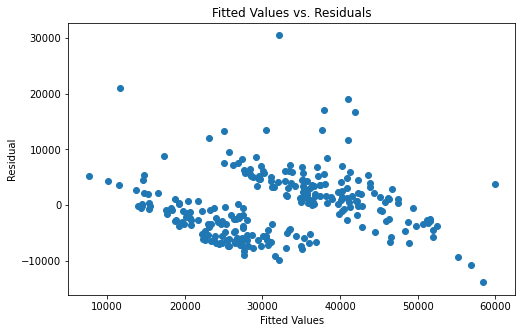

In [44]:
#Smokers
fig, ax = plt.subplots(1,1, figsize=(8,5))
lr_smk.fitted_residuals(ax=ax)
plt.show()

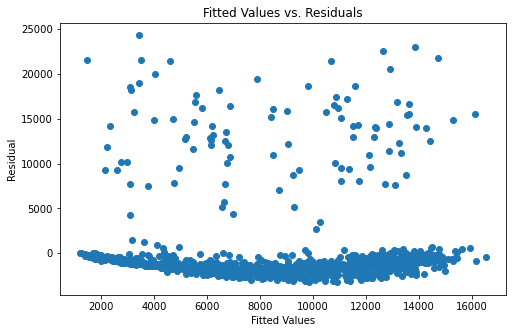

In [45]:
#Nonsmokers
fig, ax = plt.subplots(1,1, figsize=(8,5))
lr_nsmk.fitted_residuals(ax=ax)
plt.show()

In [46]:
#Smokers
lr_smk.bp_test()

{'LM Statistic': 3.128049788231241, 'LM-Test p-value': 0.8729092205977637}

In [47]:
#Nonsmokers
lr_nsmk.bp_test()

{'LM Statistic': 9.039526523851853, 'LM-Test p-value': 0.2498306519348897}

Heteroscedasticity issue is resolved!

interval columns not set, guessing: ['age', 'bmi', 'charges']


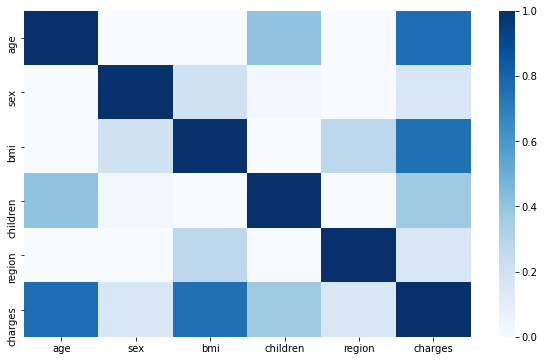

In [48]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.heatmap(smk[['age','sex','bmi','children','region','charges']].phik_matrix(),cmap = 'Blues')
plt.show()

interval columns not set, guessing: ['age', 'bmi', 'charges']


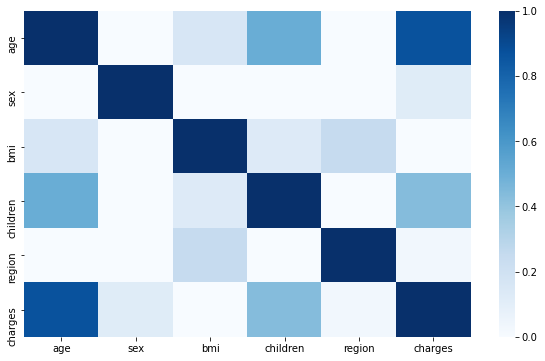

In [49]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

sns.heatmap(nsmk[['age','sex','bmi','children','region','charges']].phik_matrix(),cmap = 'Blues')
plt.show()

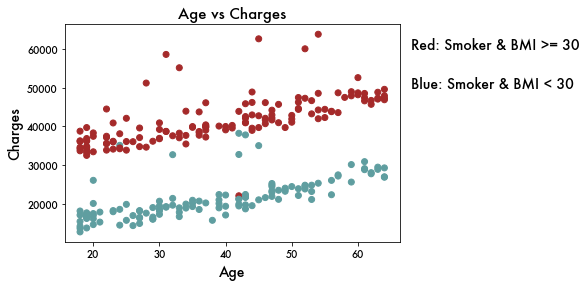

In [50]:
smk_ch = []
for i in (smk_train['bmi']):
    if i >=30:
        smk_ch.append(0)
    if i<30:
        smk_ch.append(1)
colors = {0:'brown', 1:'cadetblue'}
smk_train['bmi_bin']=smk_ch

plt.scatter(smk_train['age'], smk_train['charges'],c=smk_train['bmi_bin'].apply(lambda x: colors[x]))
plt.title('Age vs Charges',fontname='Futura',fontsize=15)
plt.text(68,60000,'Red: Smoker & BMI >= 30', fontsize=14, fontname='Futura')
plt.text(68,50000,'Blue: Smoker & BMI < 30', fontsize=14,fontname='Futura')
plt.xlabel('Age', fontsize=14, fontname='Futura')
plt.ylabel('Charges', fontsize=14, fontname='Futura')
plt.xticks(range(20,70,10), fontsize=10, fontname='Futura')
plt.yticks(range(20000,70000,10000), fontsize=10, fontname='Futura')

plt.show()

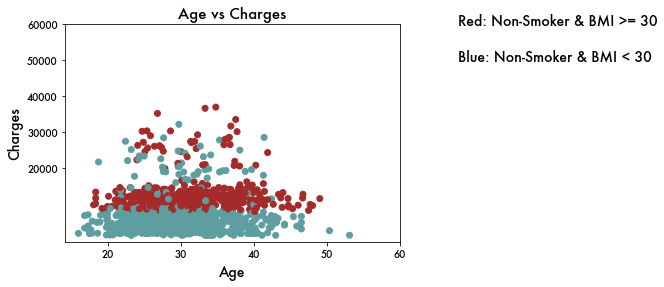

In [51]:
nsmk_ch = []
for i in (nsmk_train['age']):
    if i >45:
        nsmk_ch.append(0)
    else:
        nsmk_ch.append(1)
colors = {0:'brown', 1:'cadetblue'}
nsmk_train['bmi_bin']=nsmk_ch

plt.scatter(nsmk_train['bmi'], nsmk_train['charges'],c=nsmk_train['bmi_bin'].apply(lambda x: colors[x]))
plt.title('Age vs Charges',fontname='Futura',fontsize=15)
plt.text(68,60000,'Red: Non-Smoker & BMI >= 30', fontsize=14, fontname='Futura')
plt.text(68,50000,'Blue: Non-Smoker & BMI < 30', fontsize=14,fontname='Futura')
plt.xlabel('Age', fontsize=14, fontname='Futura')
plt.ylabel('Charges', fontsize=14, fontname='Futura')
plt.xticks(range(20,70,10), fontsize=10, fontname='Futura')
plt.yticks(range(20000,70000,10000), fontsize=10, fontname='Futura')

plt.show()

## Dropping Influential Points from Nonsmokers

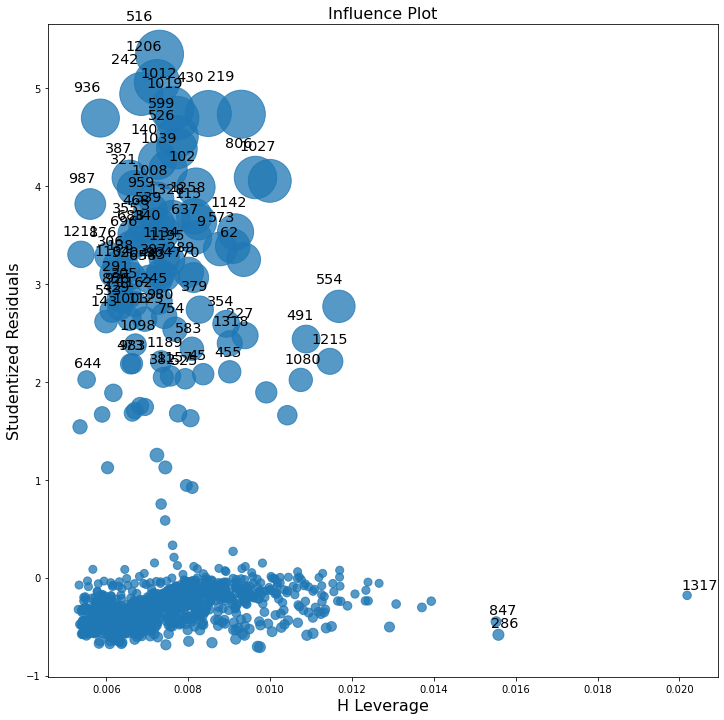

In [52]:
fig, ax = plt.subplots(figsize=(12,12))
lr_nsmk.plot_influence(ax=ax)
plt.show()

In [53]:
df_nsmk_drop = lr_nsmk.drop_influential_points()
lr_nsmk_drop = LinearRegression(y_name, X_names, df_nsmk_drop)
model_nsmk_drop = lr_nsmk_drop.fit_ols()

In [54]:
lr_nsmk_drop.bp_test()

{'LM Statistic': 9.060609477145602, 'LM-Test p-value': 0.24833378663781397}

In [55]:
model_nsmk_drop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1103.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:32:41   Log-Likelihood:                -8398.2
No. Observations:                 974   AIC:                         1.681e+04
Df Residuals:                     966   BIC:                         1.685e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3313.4701    258.345    -12.826      0.000   -3820.453   -2806.488
sex[T.male]          -479.2049     86.578     -5.535      0.000    -649.108    -309.302
children[T.1]         760.2767     87.426      8.696      0.000     588.711     931.843
region[T.northwest]  -455.5915    124.282     -3.666      0.000    -699.485    -211.698
region[T.southeast]  -637.7596    127.694     -4.994      0.000    -888.349    -387.170
region[T.southwest]  -724.2268    123.648     -5.857      0.000    -966.876    -481.578
age                   267.0626      3.128     85.376      0.000     260.924     273.201
bmi                     8.5499      7.491      1.141      0.254      -6.151      23.251
==============================================================================
Omnibus:                      966.086   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38108.058
Skew:                           4.730   Prob(JB):                         0.00
Kurtosis:                      32.147   Cond. No.                         313.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
sm.stats.anova_lm(model_nsmk_drop, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
sex,1.0,1.082798e+08,1.082798e+08,59.446605,3.116537e-14
children,1.0,2.632721e+08,2.632721e+08,144.538823,3.983990e-31
region,3.0,1.189056e+08,3.963521e+07,21.760097,1.216071e-13
age,1.0,1.357623e+10,1.357623e+10,7453.477047,0.000000e+00
bmi,1.0,2.372742e+06,2.372742e+06,1.302657,2.540113e-01
Residual,966.0,1.759533e+09,1.821463e+06,NaN,NaN


In [105]:
sm.stats.anova_lm(model_nsmk_drop, typ=2)

,sum_sq,df,F,PR(>F)
sex,5.580164e+07,1.0,30.635615,4.010654e-08
children,1.377481e+08,1.0,75.624981,1.454323e-17
region,7.192255e+07,3.0,13.162048,1.989243e-08
age,1.327684e+10,1.0,7289.109888,0.000000e+00
bmi,2.372742e+06,1.0,1.302657,2.540113e-01
Residual,1.759533e+09,966.0,NaN,NaN


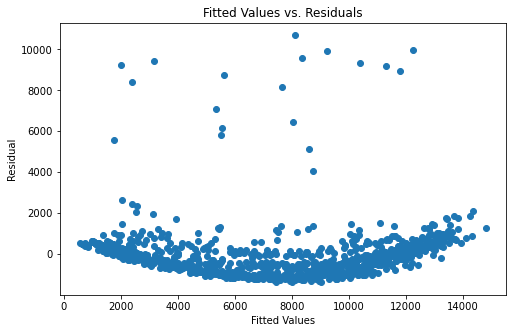

In [56]:
#Nonsmokers
fig, ax = plt.subplots(1,1, figsize=(8,5))
lr_nsmk_drop.fitted_residuals(ax=ax)
plt.show()

R-squared value has doubled from dropping the influential points. The residuals still do not form a normal distribution.

## Dropping Influential Points from Smokers

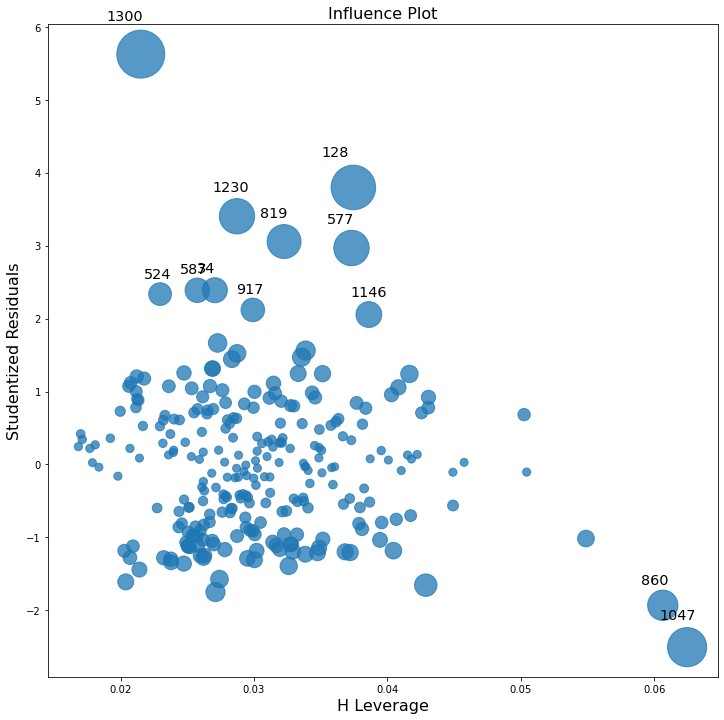

In [57]:
fig, ax = plt.subplots(figsize=(12,12))
lr_smk.plot_influence(ax=ax)
plt.show()

In [58]:
df_smk_drop = lr_smk.drop_influential_points()
lr_smk_drop = LinearRegression(y_name, X_names, df_smk_drop)
model_smk_drop = lr_smk_drop.fit_ols()

In [59]:
lr_smk_drop.bp_test()

{'LM Statistic': 8.437351322605762, 'LM-Test p-value': 0.29561145827984764}

In [60]:
model_smk_drop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     176.1
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           8.37e-92
Time:                        15:32:41   Log-Likelihood:                -2487.3
No. Observations:                 253   AIC:                             4991.
Df Residuals:                     245   BIC:                             5019.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -2.29e+04   1670.570    -13.708      0.000   -2.62e+04   -1.96e+04
sex[T.male]          -518.1649    593.459     -0.873      0.383   -1687.097     650.767
children[T.1]          63.3954    588.958      0.108      0.914   -1096.672    1223.463
region[T.northwest] -1705.0651    854.959     -1.994      0.047   -3389.073     -21.058
region[T.southeast] -1880.0160    795.994     -2.362      0.019   -3447.881    -312.151
region[T.southwest]  -661.3133    863.081     -0.766      0.444   -2361.319    1038.692
age                   254.4690     20.780     12.246      0.000     213.538     295.400
bmi                  1494.4271     49.189     30.381      0.000    1397.539    1591.315
==============================================================================
Omnibus:                       20.453   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.227
Skew:                           0.029   Prob(JB):                       0.0270
Kurtosis:                       2.174   Cond. No.                         299.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
sm.stats.anova_lm(model_smk_drop, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
sex,1.0,2.212802e+08,2.212802e+08,10.573837,1.308150e-03
children,1.0,5.302417e+07,5.302417e+07,2.533751,1.127244e-01
region,3.0,1.499917e+09,4.999723e+08,23.891093,1.346043e-13
age,1.0,4.703645e+09,4.703645e+09,224.762893,1.709222e-36
bmi,1.0,1.931614e+10,1.931614e+10,923.018461,4.653978e-85
Residual,245.0,5.127150e+09,2.092714e+07,NaN,NaN


In [110]:
sm.stats.anova_lm(model_smk_drop, typ=2)

,sum_sq,df,F,PR(>F)
sex,1.595383e+07,1.0,0.762351,3.834487e-01
children,2.424692e+05,1.0,0.011586,9.143694e-01
region,1.492707e+08,3.0,2.377625,7.046766e-02
age,3.138124e+09,1.0,149.954739,3.237261e-27
bmi,1.931614e+10,1.0,923.018461,4.653978e-85
Residual,5.127150e+09,245.0,NaN,NaN


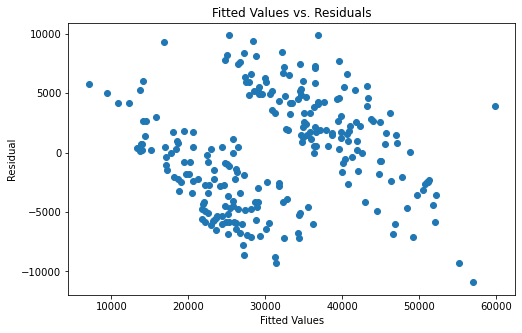

In [61]:
#smokers
fig, ax = plt.subplots(1,1, figsize=(8,5))
lr_smk_drop.fitted_residuals(ax=ax)
plt.show()

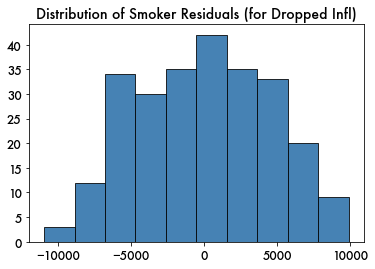

In [62]:
plot_hist(model_smk_drop.resid, 'Distribution of Smoker Residuals (for Dropped Infl)')

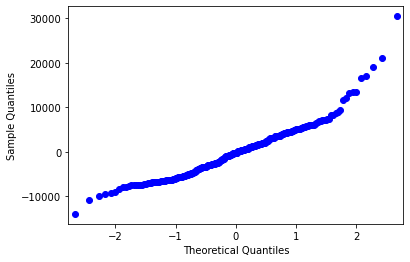

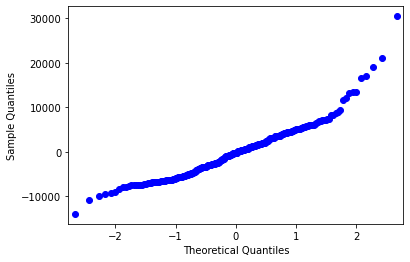

In [63]:
sm.qqplot(model_smk.resid)

In [64]:
nsmk_train['sqrt_charges'] = nsmk_train['charges']**(1/2)
smk_train['sqrt_charges'] = smk_train['charges']**(1/2)

In [65]:
# Model with influential points
X_names = ['age', 'sex', 'bmi', 'children', 'region']
lr_smk_sqrt = LinearRegression(y_name, X_names, smk_train)
lr_nsmk_sqrt = LinearRegression(y_name, X_names, nsmk_train)

model_smk_sqrt = lr_smk_sqrt.fit_ols()
model_nsmk_sqrt = lr_nsmk_sqrt.fit_ols()

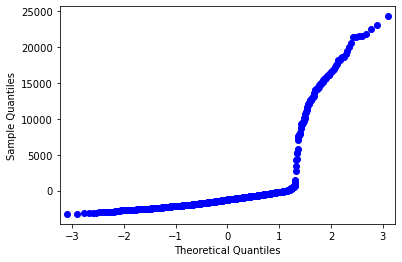

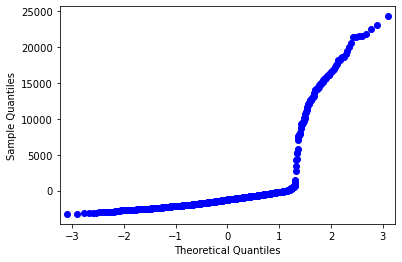

In [66]:
sm.qqplot(model_nsmk_sqrt.resid)

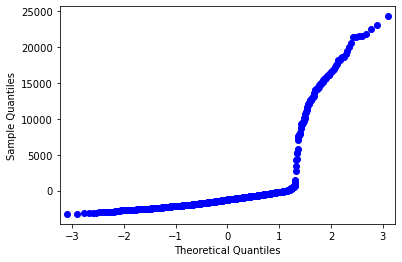

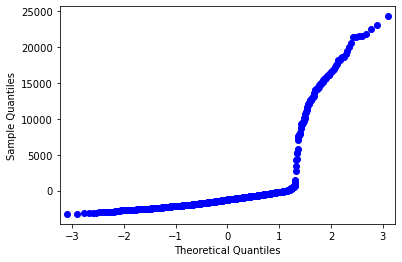

In [67]:
sm.qqplot(model_nsmk.resid)

The QQ plot makes it evident that the data appears to come from two different populations.

In [68]:
from scipy import stats 

fitted_data, fitted_lambda = stats.yeojohnson(model_smk_drop.resid) 

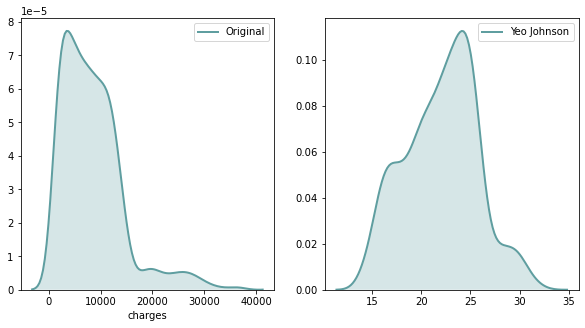

In [69]:
fitted_data, fitted_lambda = stats.yeojohnson(nsmk_train['charges']) 

fig, ax = plt.subplots(1, 2) 
   
sns.distplot(nsmk_train['charges'], hist = False, kde = True, label = "Original",
             kde_kws = {'shade': True, 'linewidth': 2}, color ="cadetblue", ax = ax[0]) 
  
sns.distplot(fitted_data, hist = False, kde = True, label = "Yeo Johnson", 
            kde_kws = {'shade': True, 'linewidth': 2}, color ="cadetblue", ax = ax[1]) 
  
plt.legend(loc = "upper right") 
  
fig.set_figheight(5) 
fig.set_figwidth(10) 

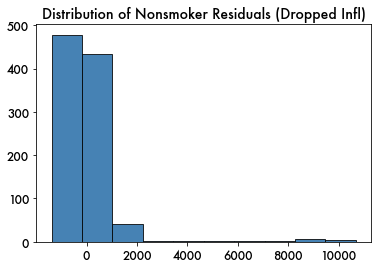

In [70]:
plot_hist(model_nsmk_drop.resid, 'Distribution of Nonsmoker Residuals (Dropped Infl)')

## Yeo Johnson Transformation for Normality

In [71]:
fitted_data, fitted_lambda = stats.yeojohnson(df_nsmk_drop['charges']) 
df_nsmk_drop['charges_bc'] = fitted_data

In [72]:
model_nsmk_drop_yj = smf.ols('charges_bc~age+bmi+C(sex)+C(children)+C(region)',data=df_nsmk_drop).fit()

In [73]:
model_nsmk_drop_yj.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             charges_bc   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     1797.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:32:42   Log-Likelihood:                -3688.4
No. Observations:                 974   AIC:                             7393.
Df Residuals:                     966   BIC:                             7432.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 27.7237      2.052     13.512      0.000      23.697      31.750
C(sex)[T.male]            -5.2506      0.688     -7.636      0.000      -6.600      -3.901
C(children)[T.1]          12.2488      0.694     17.641      0.000      10.886      13.611
C(region)[T.northwest]    -4.4913      0.987     -4.550      0.000      -6.428      -2.554
C(region)[T.southeast]    -7.7220      1.014     -7.614      0.000      -9.712      -5.732
C(region)[T.southwest]    -7.4038      0.982     -7.539      0.000      -9.331      -5.477
age                        2.6770      0.025    107.753      0.000       2.628       2.726
bmi                        0.0635      0.059      1.067      0.286      -0.053       0.180
==============================================================================
Omnibus:                     1021.545   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46870.792
Skew:                           5.129   Prob(JB):                         0.00
Kurtosis:                      35.399   Cond. No.                         313.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
BP_test(model_nsmk_drop_yj)

{'LM Statistic': 9.9925519884426, 'LM-Test p-value': 0.18899593280086355}

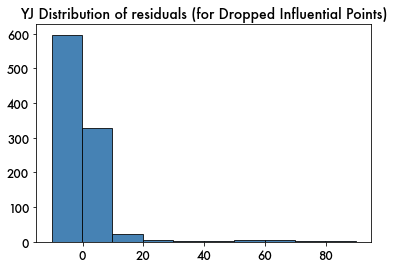

In [75]:
plot_hist(model_nsmk_drop_yj.resid, 'YJ Distribution of residuals (for Dropped Influential Points)')

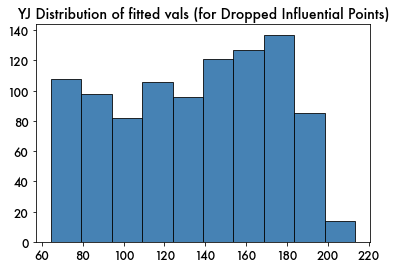

In [76]:
plot_hist(model_nsmk_drop_yj.fittedvalues, 'YJ Distribution of fitted vals (for Dropped Influential Points)')

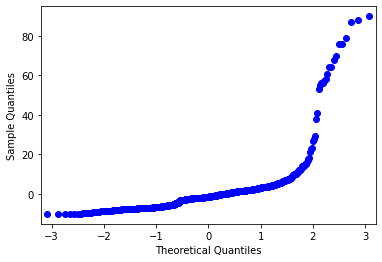

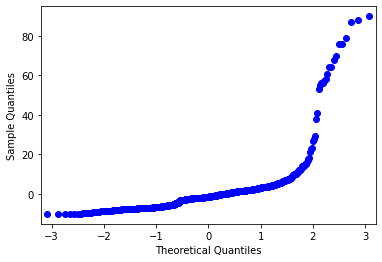

In [77]:
sm.qqplot(model_nsmk_drop_yj.resid)

## Nonsmokers Best Model Original

In [78]:
model = ModelSelection(y_name,X_names, nsmk_train)
summary = model.summary()
summary[:15]

,Number of predictors,Adj_R2,Cp,AIC,BIC,Predictors
27,4,0.407557,4.649623,20787.853057,20822.575492,"age, sex, children, region"
31,5,0.407359,6.000000,20789.197997,20828.880778,"age, sex, bmi, children, region"
25,3,0.406168,6.110407,20789.327690,20819.089776,"age, children, region"
29,4,0.405937,7.517123,20790.731254,20825.453688,"age, bmi, children, region"
11,3,0.402037,13.429053,20794.643630,20814.485021,"age, sex, children"
9,2,0.400728,14.758896,20795.951215,20810.832258,"age, children"
15,4,0.401515,15.344529,20796.559536,20821.361274,"age, sex, bmi, children"
13,3,0.400195,16.692971,20797.885831,20817.727222,"age, bmi, children"
19,3,0.397550,21.379405,20804.514176,20834.276263,"age, sex, region"
23,4,0.397385,22.655167,20805.796857,20840.519291,"age, sex, bmi, region"


In [79]:
nonsmoker_model =smf.ols('charges~sex+children+region+age',data=nsmk_train).fit()

In [80]:
## test
X_1=sm.add_constant(x)

In [81]:
## test
nonsmoker_model =smf.ols('charges~sex+children+region+age',data=nsmk_train).fit()

In [82]:
nonsmoker_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     121.7
Date:                Wed, 02 Dec 2020   Prob (F-statistic):          1.12e-116
Time:                        15:32:43   Log-Likelihood:                -10387.
No. Observations:                1054   AIC:                         2.079e+04
Df Residuals:                    1047   BIC:                         2.082e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1718.6043    533.229     -3.223      0.001   -2764.923    -672.285
sex[T.male]          -530.0697    285.080     -1.859      0.063   -1089.464      29.324
children[T.1]        1245.8289    288.079      4.325      0.000     680.551    1811.107
region[T.northwest]  -582.1184    406.852     -1.431      0.153   -1380.457     216.220
region[T.southeast]  -956.7534    403.010     -2.374      0.018   -1747.552    -165.954
region[T.southwest] -1397.8220    405.987     -3.443      0.001   -2194.463    -601.181
age                   265.4372     10.145     26.165      0.000     245.531     285.343
==============================================================================
Omnibus:                      687.863   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5247.879
Skew:                           3.115   Prob(JB):                         0.00
Kurtosis:                      11.983   Cond. No.                         198.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Nonsmokers Best Model Without Influential Points

In [83]:
model = ModelSelection(y_name,X_names, df_nsmk_drop)
summary = model.summary()
summary[:15]

,Number of predictors,Adj_R2,Cp,AIC,BIC,Predictors
27,4,0.887998,5.303283,16811.728485,16845.898364,"age, sex, children, region"
31,5,0.888033,6.000000,16812.415924,16851.467215,"age, sex, bmi, children, region"
25,3,0.884597,33.765207,16839.868956,16869.157424,"age, children, region"
29,4,0.884601,34.696909,16840.825556,16874.995435,"age, bmi, children, region"
11,3,0.883936,39.493266,16843.443791,16862.969436,"age, sex, children"
15,4,0.883817,41.486145,16845.436893,16869.843950,"age, sex, bmi, children"
9,2,0.880650,67.021094,16869.634832,16884.279066,"age, children"
13,3,0.880527,69.020746,16871.634505,16891.160150,"age, bmi, children"
19,3,0.879353,79.194418,16883.151309,16912.439777,"age, sex, region"
23,4,0.879392,79.779324,16883.829636,16917.999515,"age, sex, bmi, region"


In [84]:
nonsmoker_model_drop =smf.ols('charges~sex+children+region+age',data=df_nsmk_drop).fit()

In [85]:
nonsmoker_model_drop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1287.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:32:44   Log-Likelihood:                -8398.9
No. Observations:                 974   AIC:                         1.681e+04
Df Residuals:                     967   BIC:                         1.685e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3084.9550    163.291    -18.892      0.000   -3405.400   -2764.510
sex[T.male]          -477.2769     86.575     -5.513      0.000    -647.174    -307.380
children[T.1]         760.8267     87.438      8.701      0.000     589.236     932.417
region[T.northwest]  -454.9117    124.300     -3.660      0.000    -698.840    -210.984
region[T.southeast]  -599.0903    123.136     -4.865      0.000    -840.736    -357.445
region[T.southwest]  -712.8509    123.264     -5.783      0.000    -954.747    -470.954
age                   267.5481      3.099     86.320      0.000     261.466     273.631
==============================================================================
Omnibus:                      965.715   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38012.081
Skew:                           4.728   Prob(JB):                         0.00
Kurtosis:                      32.107   Cond. No.                         200.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Smokers Best Model Original

In [86]:
model = ModelSelection(y_name, X_names, smk_train)
summary = model.summary()
summary[:15]

,Number of predictors,Adj_R2,Cp,AIC,BIC,Predictors
5,2,0.749762,2.173535,5326.129806,5336.857653,"age, bmi"
21,3,0.750500,2.412817,5328.298499,5349.754193,"age, bmi, region"
7,3,0.749166,3.794278,5327.744690,5342.048487,"age, sex, bmi"
23,4,0.749935,4.001370,5329.869919,5354.901563,"age, sex, bmi, region"
13,3,0.748804,4.169553,5328.125765,5342.429562,"age, bmi, children"
29,4,0.749546,4.403079,5330.280649,5355.312293,"age, bmi, children, region"
15,4,0.748198,5.793497,5329.743897,5347.623642,"age, sex, bmi, children"
31,5,0.748968,6.000000,5331.860555,5360.468147,"age, sex, bmi, children, region"
4,1,0.648291,107.075509,5415.003548,5422.155446,bmi
12,2,0.648004,107.972943,5416.209392,5426.937239,"bmi, children"


age, bmi
age,bmi,region
age, sex, bmi
age, sex, bmi, region

In [87]:
smoker_model =smf.ols('charges~age+bmi',data=smk_train).fit()

In [88]:
smoker_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     395.0
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           1.13e-79
Time:                        15:32:44   Log-Likelihood:                -2660.1
No. Observations:                 264   AIC:                             5326.
Df Residuals:                     261   BIC:                             5337.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.196e+04   1960.258    -11.200      0.000   -2.58e+04   -1.81e+04
age          264.7478     25.565     10.356      0.000     214.407     315.088
bmi         1425.2750     56.125     25.395      0.000    1314.760    1535.790
==============================================================================
Omnibus:                       57.996   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.896
Skew:                           1.040   Prob(JB):                     5.10e-30
Kurtosis:                       5.817   Cond. No.                         279.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Smokers Best Model Without Influential Points

In [89]:
model = ModelSelection(y_name,X_names, df_smk_drop)
summary = model.summary()
summary[:15]

,Number of predictors,Adj_R2,Cp,AIC,BIC,Predictors
21,3,0.830302,2.754616,4987.351110,5008.551446,"age, bmi, region"
23,4,0.830134,4.003550,4988.574718,5013.308444,"age, sex, bmi, region"
29,4,0.829614,4.760419,4989.348775,5014.082501,"age, bmi, children, region"
5,2,0.827604,5.704326,4988.396120,4998.996288,"age, bmi"
31,5,0.829449,6.000000,4990.562753,5018.829869,"age, sex, bmi, children, region"
7,3,0.827273,7.176401,4989.867024,5004.000582,"age, sex, bmi"
13,3,0.826928,7.679815,4990.371579,5004.505137,"age, bmi, children"
15,4,0.826607,9.132875,4991.823353,5009.490300,"age, sex, bmi, children"
28,3,0.726006,155.023564,5108.559526,5129.759863,"bmi, children, region"
30,4,0.726179,155.165754,5109.373533,5134.107259,"sex, bmi, children, region"


In [90]:
smoker_model_drop =smf.ols('charges~age+bmi',data=df_smk_drop).fit()

In [91]:
smoker_model_drop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     605.9
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           1.36e-96
Time:                        15:32:44   Log-Likelihood:                -2491.2
No. Observations:                 253   AIC:                             4988.
Df Residuals:                     250   BIC:                             4999.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.329e+04   1598.736    -14.566      0.000   -2.64e+04   -2.01e+04
age          253.5351     20.620     12.295      0.000     212.923     294.147
bmi         1462.8602     46.622     31.377      0.000    1371.037    1554.683
==============================================================================
Omnibus:                       38.620   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.908
Skew:                           0.045   Prob(JB):                      0.00706
Kurtosis:                       2.035   Cond. No.                         280.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Non-linearity

### Non-smokers

In [164]:
def Predictors_Residual(model, df, X_names, axes):
    '''
    plot residuals against all predictors
    '''
    axes = axes.flatten()
    i = 0
    for col in X_names:
        axes[i].scatter(df[col].values, model.resid)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("residuals")
        axes[i].set_title(col)
        i += 1

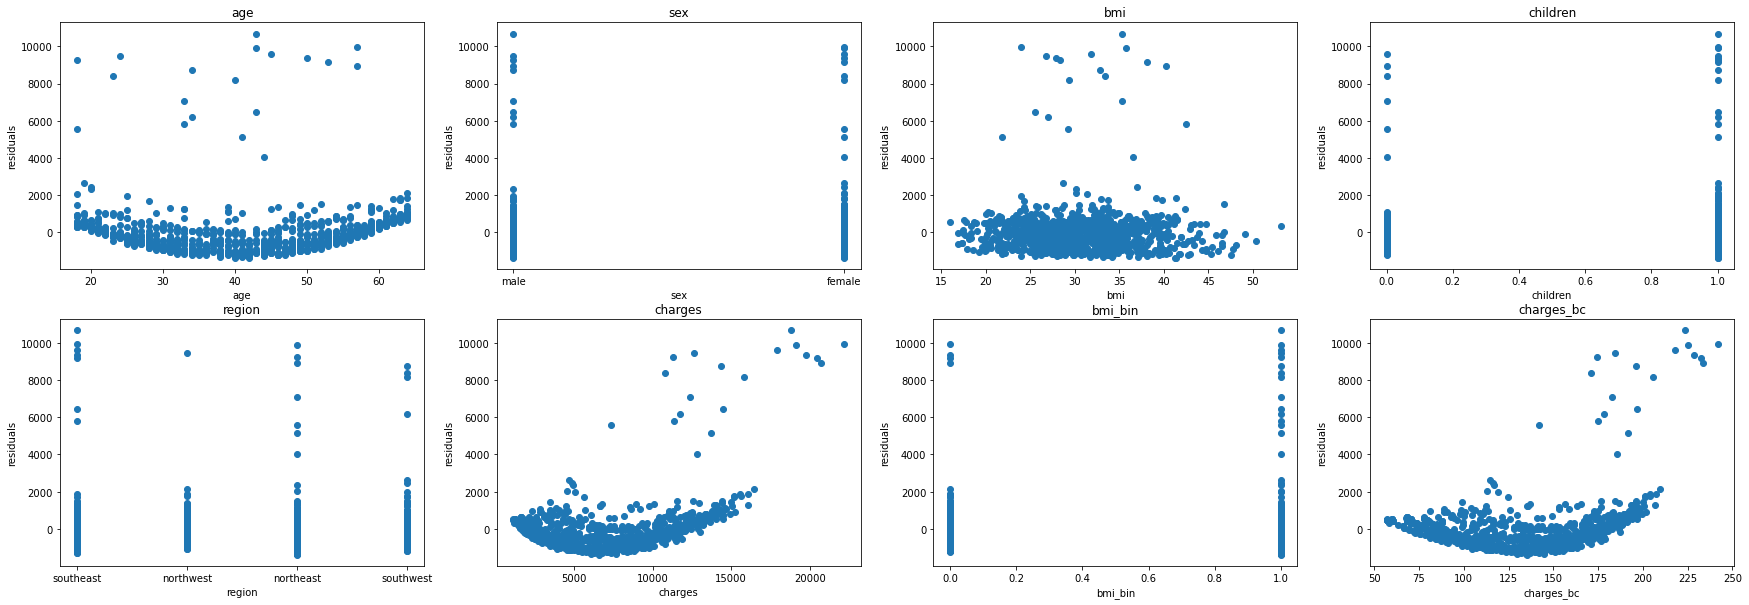

In [165]:
# non-smokers with dropped influential points
fig, axes = plt.subplots(2, 4 ,figsize=(30,10))
Predictors_Residual(model_nsmk_drop, df_nsmk_drop, list(df_nsmk_drop.columns), axes)
plt.show()

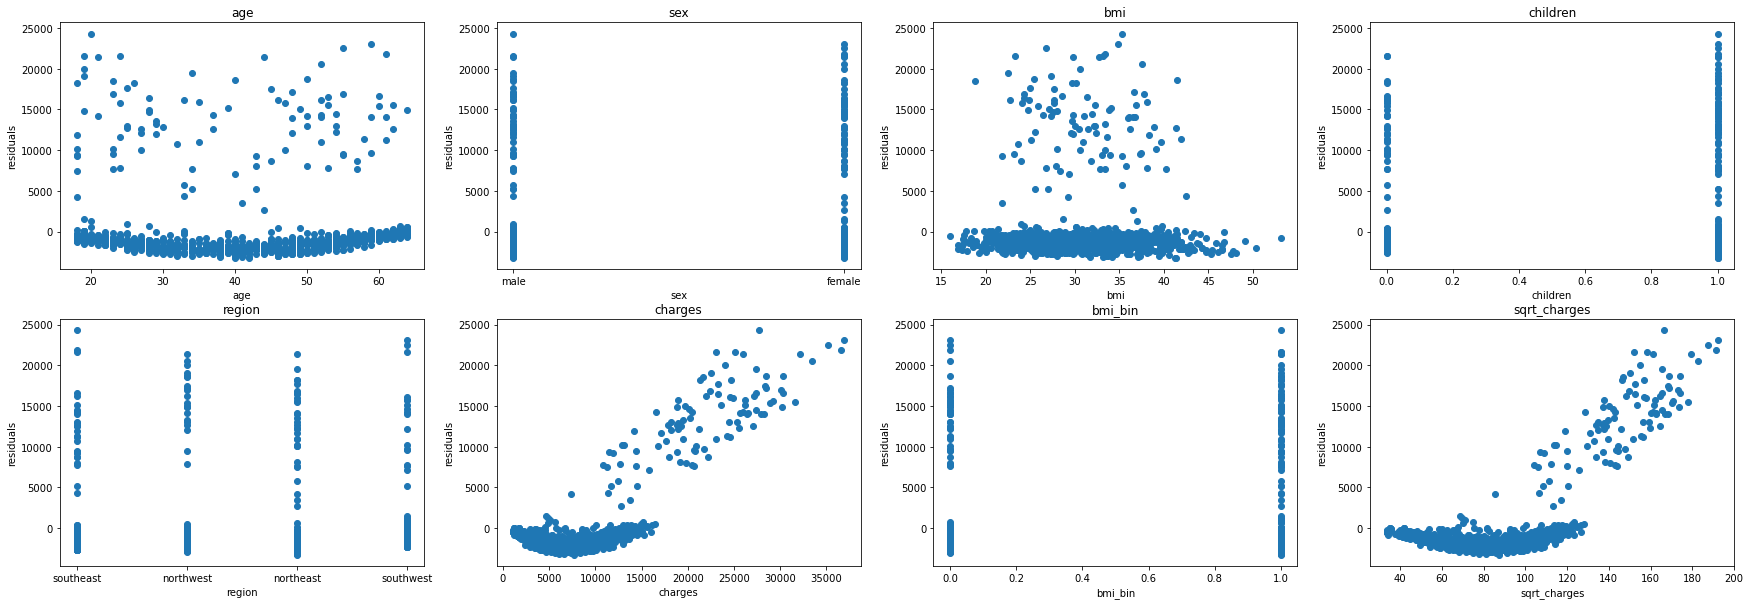

In [166]:
# non-smokers
fig, axes = plt.subplots(2, 4 ,figsize=(30,10))
Predictors_Residual(model_nsmk, nsmk_train, list(nsmk_train.columns), axes)
plt.show()

### Smokers

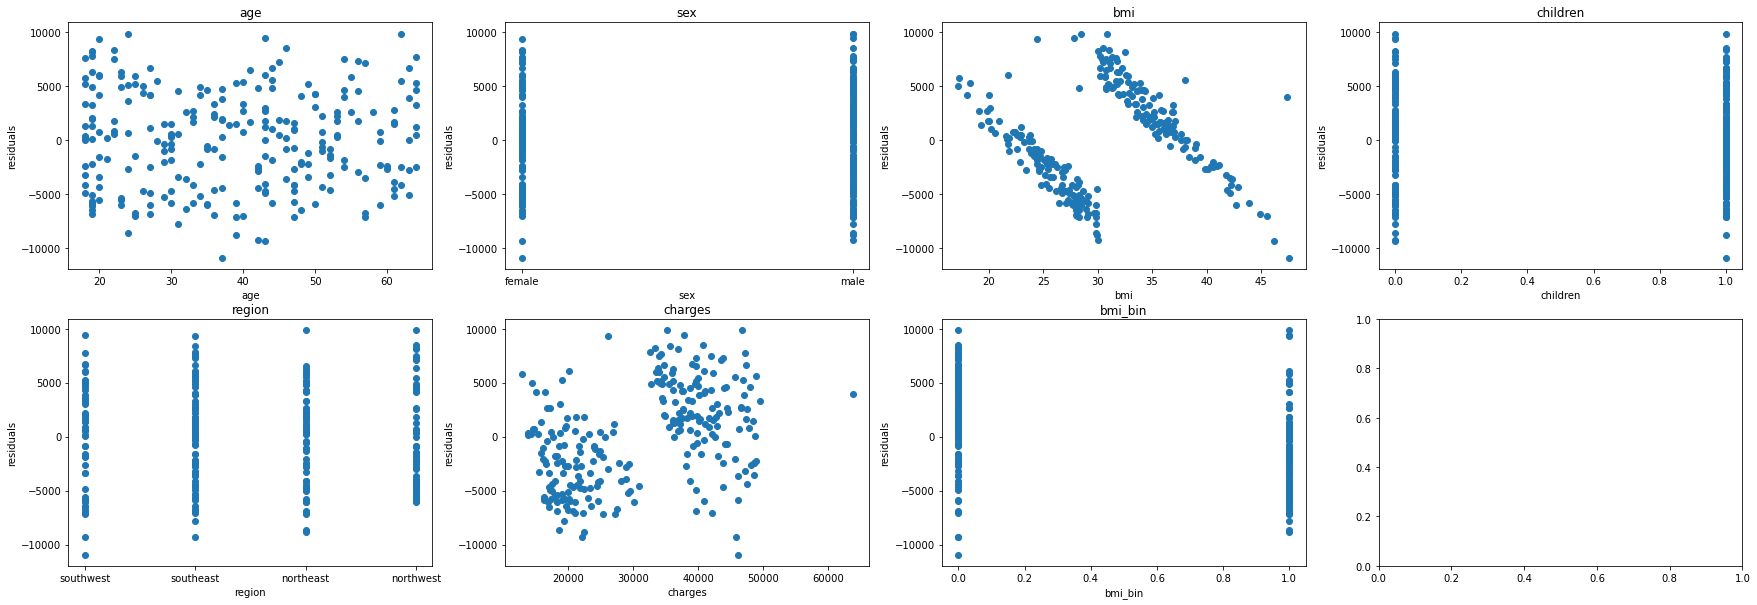

In [167]:
# smokers with dropped influential points
fig, axes = plt.subplots(2, 4 ,figsize=(30,10))
Predictors_Residual(model_smk_drop, df_smk_drop, list(df_smk_drop.columns), axes)
plt.show()

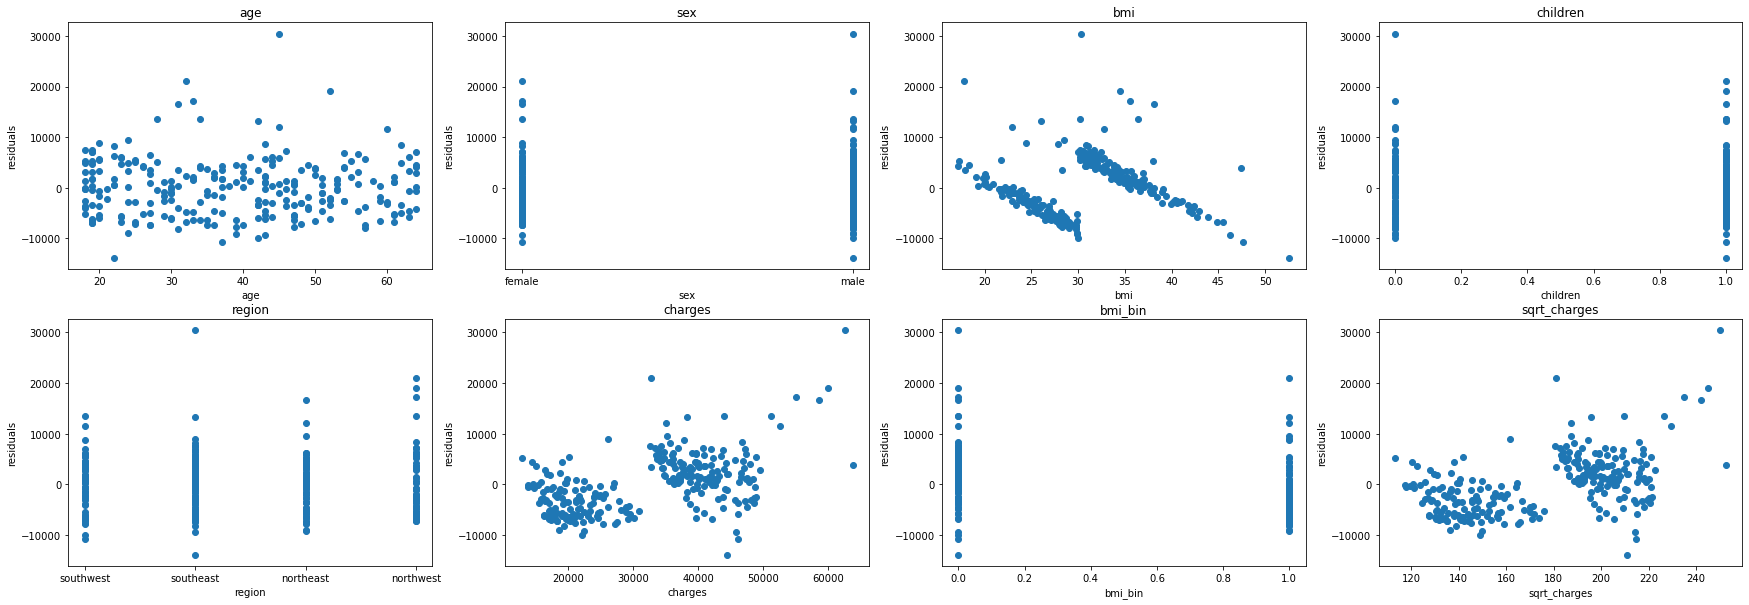

In [168]:
# smokers
fig, axes = plt.subplots(2, 4 ,figsize=(30,10))
Predictors_Residual(model_smk, smk_train, list(smk_train.columns), axes)
plt.show()

## Testing the Accuracy of our Models

In [96]:
smk_test = sm.add_constant(smk_test[['age','bmi','charges']])
smk_test.head()

,const,age,bmi,charges
750,1.0,37,26.40,19539.2430
909,1.0,32,24.60,17496.3060
240,1.0,23,36.67,38511.6283
1112,1.0,48,25.85,24180.9335
1111,1.0,38,38.39,41949.2441


In [97]:
nsmk_test = sm.add_constant(nsmk_test[['age','sex','children','region','charges']])
nsmk_test.head()

,const,age,sex,children,region,charges
817,1.0,23,male,1,southwest,3597.59600
1242,1.0,22,female,1,northwest,4296.27120
875,1.0,23,female,0,northwest,2690.11380
921,1.0,62,female,0,southwest,13462.52000
884,1.0,25,male,1,northwest,4877.98105


In [98]:
from sklearn.metrics import r2_score

In [99]:
def adjr_squared(r_squared, n, p):
    return 1-(1-r_squared)*(n-1)/(n-p-1)

In [100]:
#SMOKER ORIGINAL 
smoker_actual = smk_test['charges'].values.round(2)
smoker_pred = round(smoker_model.predict(smk_test),2)
r2_smoker = r2_score(smoker_actual, smoker_pred.values)

#SMOKER DROPPED
smoker_drop_actual = smk_test['charges'].values.round(2)
smoker_drop_pred = round(smoker_model_drop.predict(smk_test),2)
r2_smoker_drop = r2_score(smoker_drop_actual, smoker_drop_pred.values)

#NONSMOKER ORIGINAL
nonsmoker_actual = nsmk_test['charges'].values.round(2)
nonsmoker_pred = round(nonsmoker_model.predict(nsmk_test),2)
r2_nonsmoker = r2_score(nonsmoker_actual,nonsmoker_pred.values)

#NONSMOKER DROPPED
nonsmoker_drop_actual = nsmk_test['charges'].values.round(2)
nonsmoker_drop_pred = round(nonsmoker_model_drop.predict(nsmk_test),2)
r2_nonsmoker_drop = r2_score(nonsmoker_drop_actual,nonsmoker_drop_pred.values)

In [101]:
df_results = pd.DataFrame(list(zip(smoker_actual, smoker_pred,smoker_drop_actual, smoker_drop_pred,
                          nonsmoker_actual, nonsmoker_pred, nonsmoker_drop_actual, nonsmoker_drop_pred)), 
               columns =['SM Act', 'SM Pred', 'SM Act Drop','SM Pred Drop',
                        'NSMK Act', 'NSMK Pred', 'NSMK Act Drop','NSMK Pred Drop']) 
df_results.loc['R2'] = [None, round(r2_smoker,2), None, round(r2_smoker_drop,2), None, round(r2_nonsmoker,2), None, round(r2_nonsmoker_drop,2)]
df_results.loc['adjR2'] = [None, round(adjr_squared(r2_smoker, 10, 2),2), None, round(adjr_squared(r2_smoker_drop, 10, 2),2), 
                   None, round(adjr_squared(r2_nonsmoker, 10, 4),2), None, round(adjr_squared(r2_nonsmoker_drop, 10, 4),2)]


In [102]:
df_results

,SM Act,SM Pred,SM Act Drop,SM Pred Drop,NSMK Act,NSMK Pred,NSMK Act Drop,NSMK Pred Drop
0,19539.24,25467.89,19539.24,24713.82,3597.60,3704.39,3597.60,2639.35
1,17496.31,21578.65,17496.31,20813.00,4296.27,4784.73,4296.27,3107.02
2,38511.63,36398.99,38511.63,36187.90,2690.11,3804.33,2690.11,2613.74
3,24180.93,27596.21,24180.93,26698.13,13462.52,13340.68,13462.52,12790.18
4,41949.24,42821.68,41949.24,42507.05,4877.98,5050.97,4877.98,3432.39
5,21659.93,23845.22,21659.93,23011.97,6555.07,9613.84,6555.07,7842.70
6,45008.96,40180.00,45008.96,39395.43,4906.41,6642.79,4906.41,4979.85
7,46130.53,38612.20,46130.53,37786.29,7345.73,9984.27,7345.73,8581.35
8,34838.87,29946.78,34838.87,29492.77,13880.95,13606.12,13880.95,13057.72
9,44585.46,36319.91,44585.46,35997.57,4433.39,6112.72,4433.39,4502.58


In [157]:
def plot_test_results(col1, col2, df, ax):
    ax.plot(df[col1], df[col1], color='blue')
    ax.scatter(df[col1], df[col2], color='red')
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_title(f"{col1} vs {col2}")

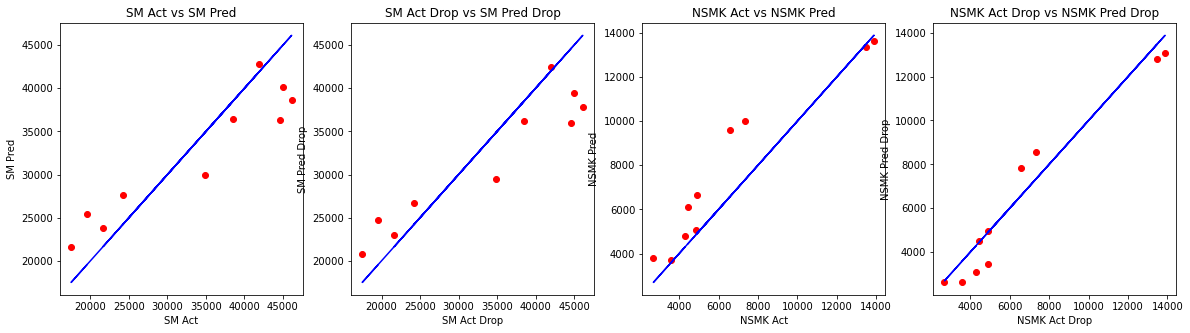

In [158]:
fig, axes = plt.subplots(1,4, figsize=(20,5))
plot_test_results('SM Act', 'SM Pred', df_results, axes[0])
plot_test_results('SM Act Drop', 'SM Pred Drop', df_results, axes[1])
plot_test_results('NSMK Act', 'NSMK Pred', df_results, axes[2])
plot_test_results('NSMK Act Drop', 'NSMK Pred Drop', df_results, axes[3])
plt.show()

## Prediction

For a 45 year old individual with a BMI of 35 in the subset population of smokers, what is the expected cost of their health insurance? 


In [153]:
pred = smoker_model.predict(pd.DataFrame({'coef':[1],'age':[45],'bmi':[35]})); round(pred[0],2)

39843.23

For a 45 year old individual living in the northwest with 3 children in the subset population of nonsmokers, what is the expected cost of their health insurance? 

In [154]:
pred = nonsmoker_model_drop.predict(pd.DataFrame({'coef':[1],'age':[45],'region':['northwest'],'children':1,'sex':'male'})); round(pred[0],2)

8783.35